### DuPont Mixture Design - Inverse Modeling

## Alison Shapiro, Sean Farrington, and Peter Osazuwa

***Machine Learning Techniques Used:*** 

Linear Regression

Gaussian Process Regression

## Script for Particle Swarm Optimization

#### Utilize predictions from the Gaussian process regression

Start by remaking the Gaussian process regression code

# Gaussian Process Regression



In [1]:
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

### Import new packages for GPR

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, WhiteKernel
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error as mape, r2_score
import matplotlib.pyplot as plt

### Import data

In [3]:
file = 'DATA/training_inputs.xlsx'

df = pd.read_excel(file)

design = ['Powdered Additive','Base Resin A','Base Resin B','Stabilizer','Temperature','Screw Speed (RPM)']
performance = ['Toughness (J/m2)','Modulus (GPa)']

X = df[design]
y = df[performance]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(data=X,
                columns=design)
# print(X)

### Create model 

***Need two separate models for each output***

In [4]:
kernel = C() + RBF(length_scale=np.ones(X.shape[1]))

# Split to two models
reg_0 = GaussianProcessRegressor(kernel=kernel,random_state=1773).fit(X,y[performance[0]])
reg_1 = GaussianProcessRegressor(kernel=kernel,random_state=1773).fit(X,y[performance[1]])

y_pred_0 = reg_0.predict(X)
y_pred_1 = reg_1.predict(X)
y_pred_GPR = pd.DataFrame({performance[0]:y_pred_0,
                       performance[1]:y_pred_1
                       })

### Are some parameters unimportant?

Start with a test set sample

In [5]:
X_test = np.array([0.32,0.6,0.05,0.09,406,120])
#X_test = np.array([0.13,0.74,0.05,0.06,389,100])
y_test = np.array([656,5.1])

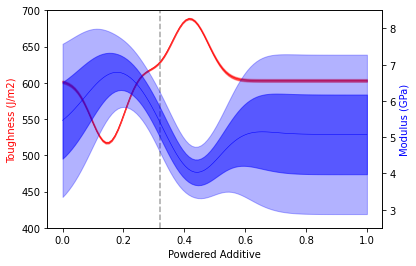

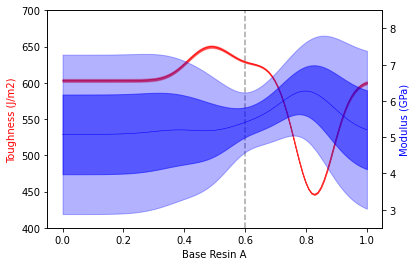

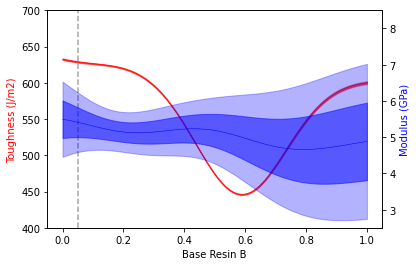

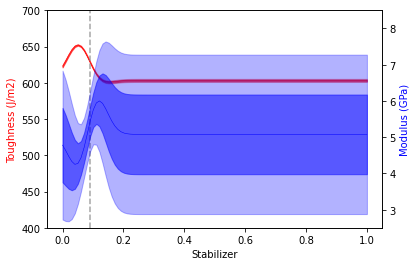

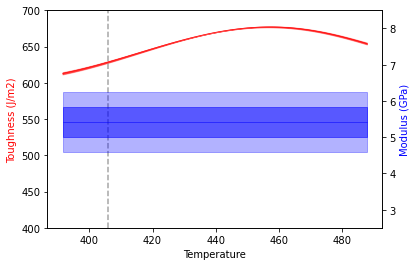

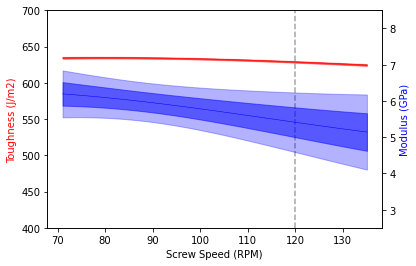

In [6]:
# Normalize the test sample
X_og_unscaled = X_test.reshape(1,-1)
n = 100

for i in (0,1,2,3):
    X_s = np.ones([n,len(X_og_unscaled)])*X_og_unscaled
    r_0 = np.zeros(4)
    
    r_ref = X_test[0:4]
    r_0[i] = 1
    
    v = r_ref - r_0
    
    t_max = -r_0[i]/v[i]
    
    t = np.linspace(0,t_max,n)
    
    for j in range(n):
        X_s[j,0:4] = r_0 + t[j]*v        
    
    X_s = scaler.transform(X_s)
    
    y_0, std_0 = reg_0.predict(X_s,return_std=True)
    y_1, std_1 = reg_1.predict(X_s,return_std=True)

    Xs_real = scaler.inverse_transform(X_s)

    fig,ax = plt.subplots()
    ax.plot(Xs_real[:,i],y_0,'r-',linewidth=0.5)
    ax.fill_between(Xs_real[:,i],y_0-std_0,y_0+std_0,color='r',alpha=0.5)
    ax.fill_between(Xs_real[:,i],y_0-2*std_0,y_0+2*std_0,color='r',alpha=0.3)
    ax.set_ylabel(performance[0],color='r')
    ax.set_ylim([400,700])
    plt.axvline(x=X_test[i],linestyle='--',color='grey',alpha=0.7)

    ax2 = ax.twinx()
    ax2.plot(Xs_real[:,i],y_1,'b-',linewidth=0.5)
    ax2.fill_between(Xs_real[:,i],y_1-std_1,y_1+std_1,color='b',alpha=0.5)
    ax2.fill_between(Xs_real[:,i],y_1-2*std_1,y_1+2*std_1,color='b',alpha=0.3)
    ax2.set_ylabel(performance[1],color='b')
    ax2.set_ylim([2.5,8.5])

    ax.set_xlabel(design[i])
    plt.savefig(f'FIGURES/tracePlot_{design[i]}.svg')
    plt.show()

X_og_scaled = scaler.transform(X_test.reshape(1,-1))    
k = np.linspace(-2,2,n)    
for i in (4,5):
    X_s = np.ones([n,len(X_og_scaled)])*X_og_scaled
    X_s[:,i] = k
    y_0,std_0 = reg_0.predict(X_s,return_std=True)
    y_1,std_1 = reg_1.predict(X_s,return_std=True)

    Xs_real = scaler.inverse_transform(X_s)

    fig,ax = plt.subplots()
    ax.plot(Xs_real[:,i],y_0,'r-',linewidth=0.5)
    ax.fill_between(Xs_real[:,i],y_0-std_0,y_0+std_0,color='r',alpha=0.5)
    ax.fill_between(Xs_real[:,i],y_0-2*std_0,y_0+2*std_0,color='r',alpha=0.3)
    ax.set_ylabel(performance[0],color='r')
    ax.set_ylim([400,700])
    plt.axvline(x=X_test[i],linestyle='--',color='grey',alpha=0.7)

    ax2 = ax.twinx()
    ax2.plot(Xs_real[:,i],y_1,'b-',linewidth=0.5)
    ax2.fill_between(Xs_real[:,i],y_1-std_1,y_1+std_1,color='b',alpha=0.5)
    ax2.fill_between(Xs_real[:,i],y_1-2*std_1,y_1+2*std_1,color='b',alpha=0.3)
    ax2.set_ylabel(performance[1],color='b')
    ax2.set_ylim([2.5,8.5])

    ax.set_xlabel(design[i])
    plt.savefig(f'FIGURES/tracePlot_{design[i]}.svg')
    plt.show()

# Particle Swarm Routine

In this inverse model we will try to predict a data point from the testing set

The values for this datum is as follows:

- Powdered Additive: 0.32
- Base Resin A: 0.6
- Base Resin B: 0.05
- Stabilizer: 0.09
- Temperature: 406
- Screw Speed (RPM): 120


- Toughness (J/m2): 656
- Modulus (GPa): 5.1

In [7]:
import pyswarms as ps
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

X_true = np.array([0.32,0.6,0.05,0.09,406,120])
y_true = np.array([656,5.1])

def CostFuncSlack(x,a,b):
    """
    Input 'x' is an array of unscaled variables. For this function they are:
    
    x = ['Powdered Additive','Base Resin A','Base Resin B','Temperature','Screw Speed']
    
    Notice that 'Stabilizer' is removed from this array, this must be accounted for so 
    scaling is done properly.
    
    Use 'y_0_target' and 'y_1_target' to assign the desired performance
    
    The cost function uses the slack variable approach to reduce
    dimensionality and ensure the composition is real.
    
    The barrier term here is a large penalty associated with the first three components 
    being greater than or equal to 1
    
    """
    y_0_target = a # Target toughness (J/m2)
    y_1_target = b # Target Modulus (GPa)
    
    sum_noslack = x[:,0]+x[:,1]+x[:,2]
    
    slack = 1 - (sum_noslack)
    
    x_full = np.insert(x,3,slack,axis=1) # Insert in the fourth column of the array
    
    x_scaled = scaler.transform(x_full)
    
    y_0,std_0 = reg_0.predict(x_scaled,return_std=True)
    y_1,std_1 = reg_1.predict(x_scaled,return_std=True)
    
    var_0 = std_0**2/y_0_target # Variance normalized by the target value
    var_1 = std_1**2/y_1_target # Variance normalized by the target value
    
    y_0_penalty = ((y_0-y_0_target)/y_0_target)**2
    y_1_penalty = ((y_1-y_1_target)/y_1_target)**2
    
    barrier = np.zeros(len(x_full[:,0]))
    
    for i in range(len(x_full[:,0])):
        if sum_noslack[i] >= 1:
            barrier[i] = 1e6
            
    loss = y_0_penalty + y_1_penalty + var_0 + var_1 + barrier
    return loss

# Particle swarm optimization

In [8]:
import time
start_time = time.time()

# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
max_bound = np.array([1,1,1,475,121])
min_bound = np.array([0,0,0,380,79])
bounds = (min_bound,max_bound)

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=len(X.columns)-1, options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(CostFuncSlack, iters=10_000, a = y_true[0], b = y_true[1])

# pos_unscaled = scaler.inverse_transform(pos.reshape(1,-1))
print(f'Best Cost = {cost}')
print('--- %s seconds ---' % (time.time()-start_time))

2023-05-11 13:48:33,896 - pyswarms.single.global_best - INFO - Optimize for 10000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████|10000/10000, best_cost=0.00148
2023-05-11 13:48:47,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0014796118061672406, best pos: [3.00751129e-01 4.38775735e-01 2.00656995e-01 4.58362868e+02
 8.71851182e+01]


Best Cost = 0.0014796118061672406
--- 13.896983623504639 seconds ---


In [9]:
Stabilizer = 1 - (pos[0]+pos[1]+pos[2])
    
pos = np.insert(pos,3,Stabilizer)

df = pd.DataFrame(data=pos.reshape(1,-1),
                index = ['Inverse Design'],
                columns = design)
df.loc['True Design'] = X_true
dif =  X_true - pos.reshape(-1)
df.loc['True - Inverse'] = dif
df.loc['Percent Difference'] = np.abs(dif/X_true)*100
df['Sum Composition'] = [np.sum(pos.reshape(-1)[0:4]),np.sum(X_true[0:4]),'N/A','N/A']

df.to_excel('ANALYSIS/PSO_noInitialization_inputs.xlsx')

df

,Powdered Additive,Base Resin A,Base Resin B,Stabilizer,Temperature,Screw Speed (RPM),Sum Composition
Inverse Design,0.300751,0.438776,0.200657,0.059816,458.362868,87.185118,1.0
True Design,0.320000,0.600000,0.050000,0.090000,406.000000,120.000000,1.06
True - Inverse,0.019249,0.161224,-0.150657,0.030184,-52.362868,32.814882,N/A
Percent Difference,6.015272,26.870711,301.313990,33.537622,12.897258,27.345735,N/A


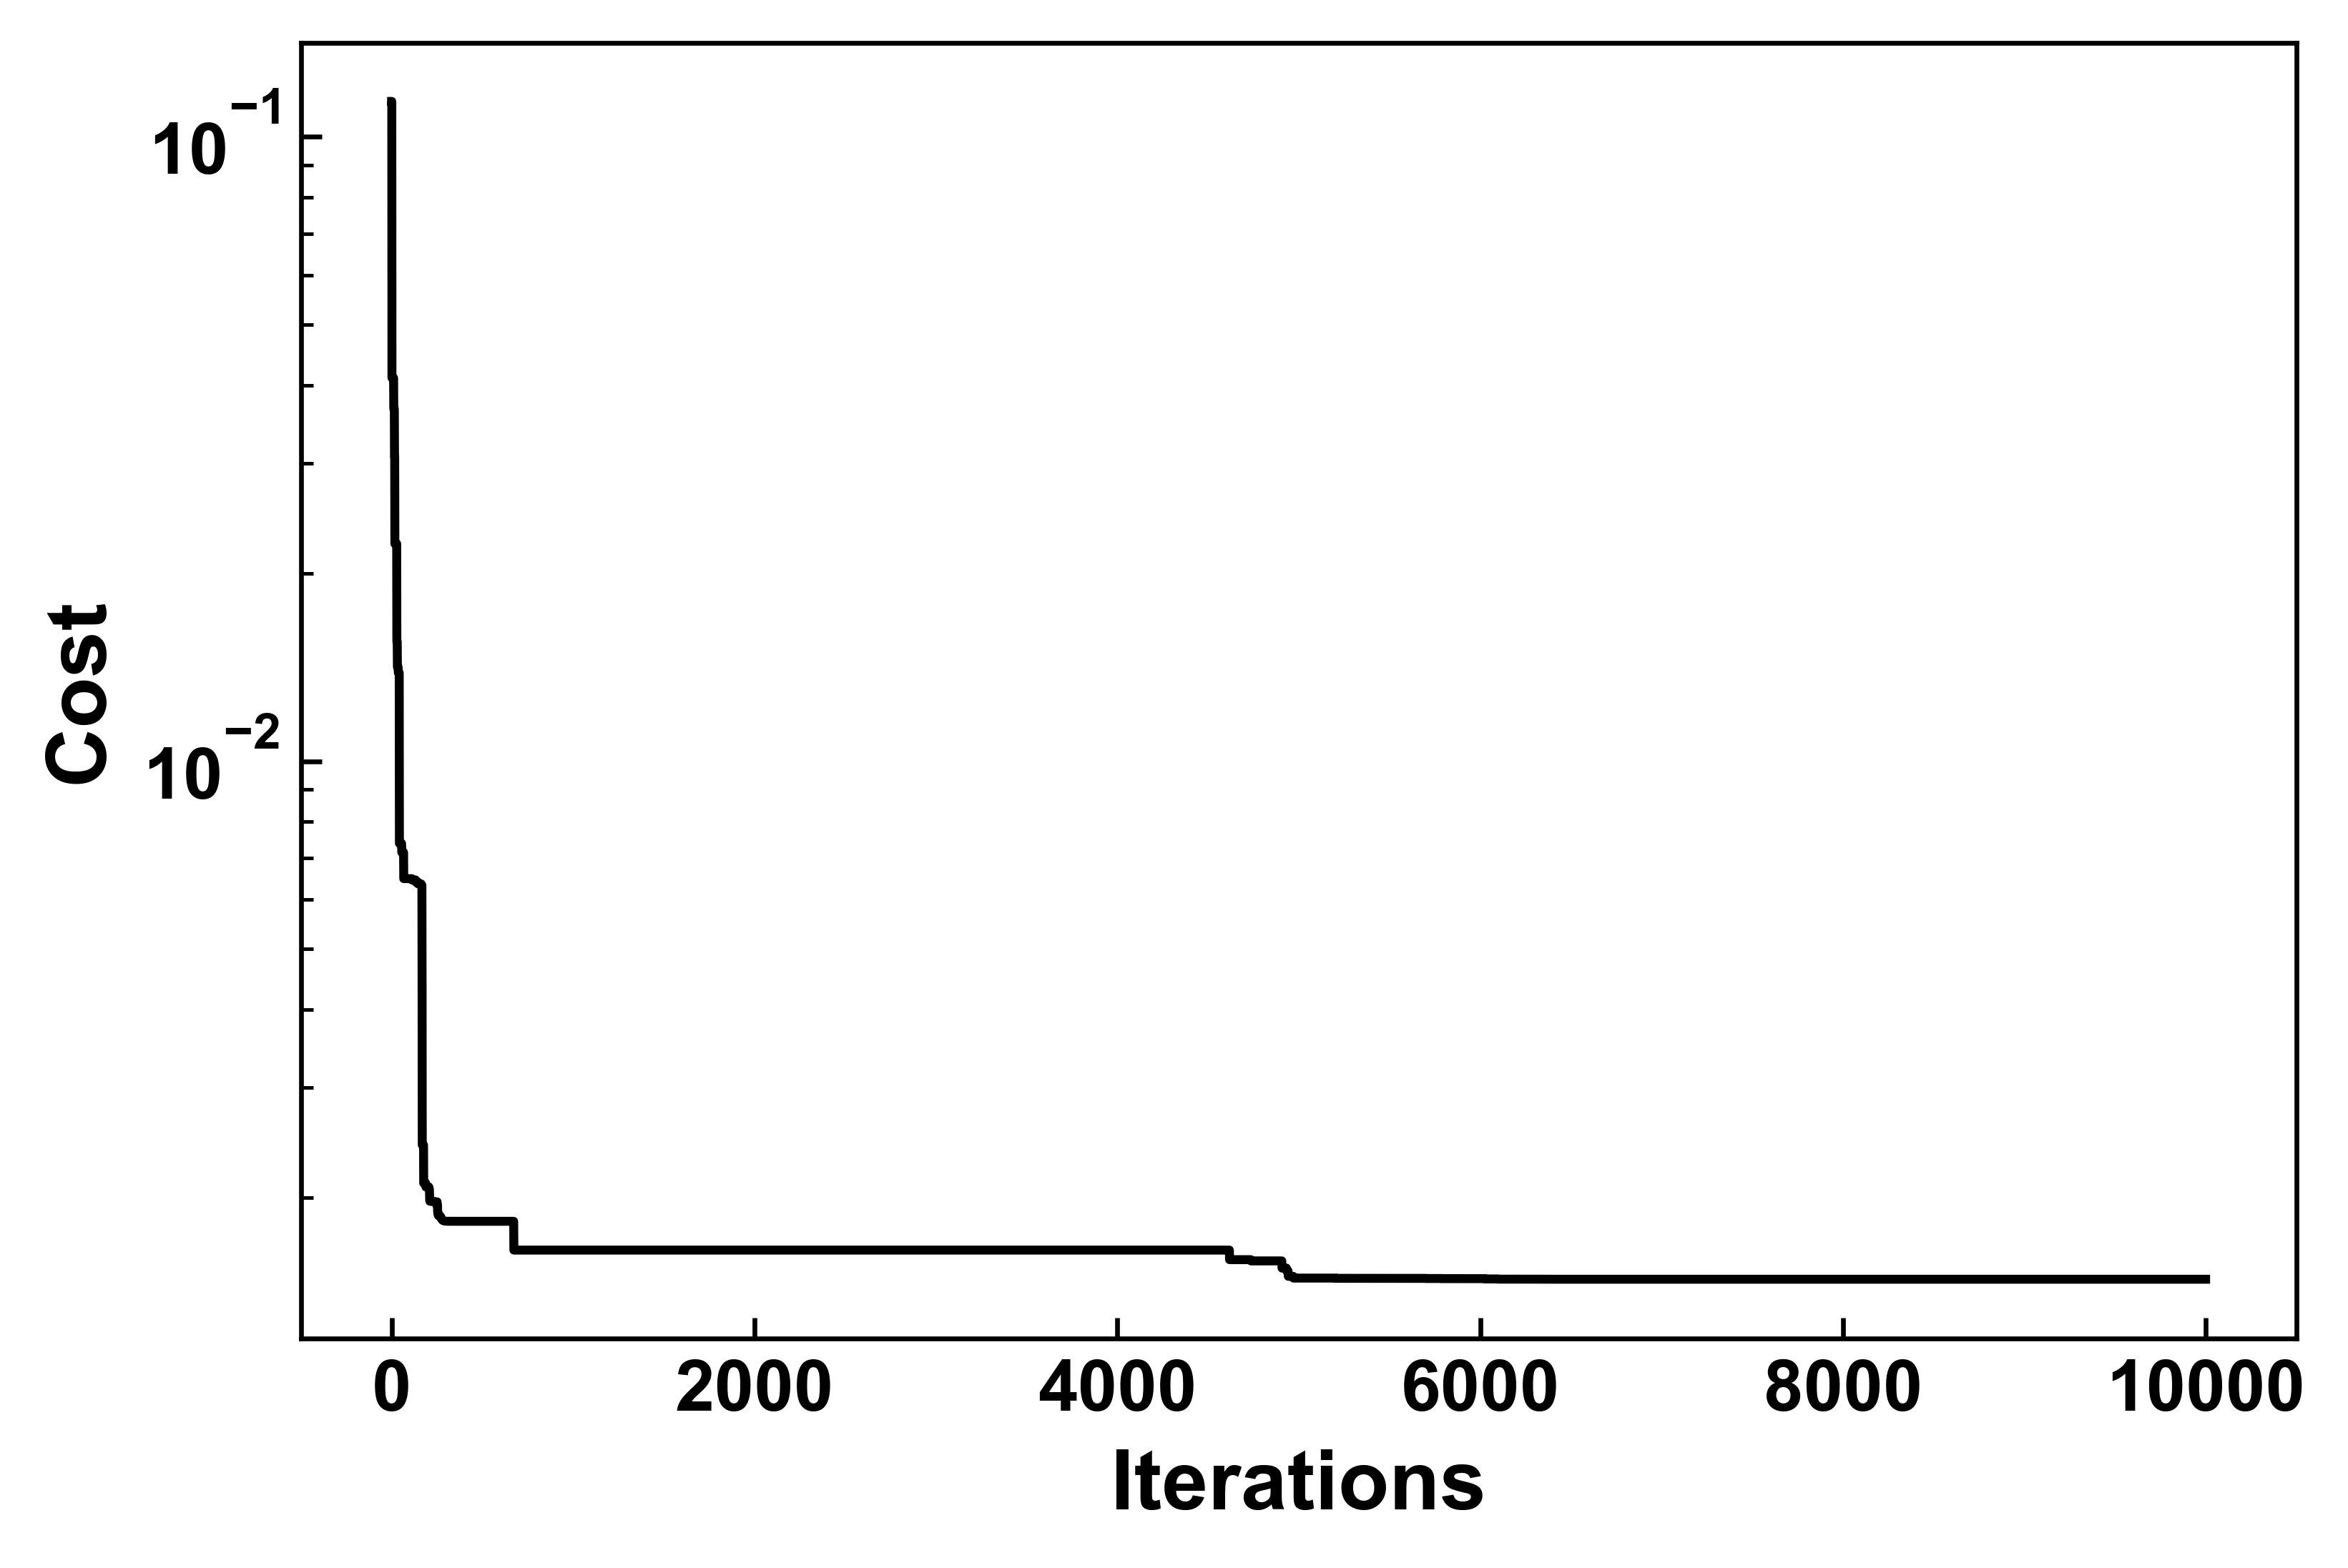

In [10]:
#plot_cost_history(cost_history=optimizer.cost_history)
med = 14
sml = 12
fontname = "Arial"
fig,ax = plt.subplots(dpi=600)
ax.plot(range(len(optimizer.cost_history)),optimizer.cost_history,'k-')
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')
ax.set_yscale('log')
ax.set_xlabel(r'Iterations',
             fontsize=med,
             fontweight="bold",
             fontname=fontname)
ax.set_ylabel(r'Cost',
             fontsize=med,
             fontweight="bold",
             fontname=fontname)
ax.tick_params(axis='both',
               which='both',
               labelsize=sml,
               direction = 'in')
plt.xticks(fontweight="bold",
           fontname=fontname)
plt.yticks(fontweight="bold",
           fontname=fontname)
plt.savefig('FIGURES/PSO_noInitialization_costPerIteration.svg')
plt.show()

In [11]:
pos_scaled = scaler.transform(pos.reshape(1,-1))
y_pred_0 = reg_0.predict(pos_scaled)
y_pred_1 = reg_1.predict(pos_scaled)
y_pred_GPR = pd.DataFrame({performance[0]:y_pred_0,
                       performance[1]:y_pred_1
                       },index=['Inverse Performance'])

y_pred_GPR.loc['True Performance'] = y_true
dif = y_pred_GPR.loc['True Performance'] - y_pred_GPR.loc['Inverse Performance']
y_pred_GPR.loc['True - Inverse'] = dif
y_pred_GPR.loc['Percent Difference'] = np.abs(dif/y_true)*100

y_pred_GPR.to_excel('ANALYSIS/PSO_noInitialization_outputs.xlsx')

y_pred_GPR

,Toughness (J/m2),Modulus (GPa)
Inverse Performance,674.467123,5.097293
True Performance,656.000000,5.100000
True - Inverse,-18.467123,0.002707
Percent Difference,2.815110,0.053071


# Particle swarm with initialization

In [12]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
max_bound = np.array([1,1,1,475,121])
min_bound = np.array([0,0,0,380,79])
bounds = (min_bound,max_bound)
n_p = 10

# Initialization
ary = np.delete(X_true,3,None)
init_pos = ary*np.ones([n_p,len(X.columns)-1])

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n_p,
                                    dimensions=len(X.columns)-1,
                                    options=options,
                                    bounds=bounds,
                                    init_pos = init_pos)

# Perform optimization
cost, pos = optimizer.optimize(CostFuncSlack,
                               iters=10_000,
                               a = y_true[0],
                               b = y_true[1])

# pos_unscaled = scaler.inverse_transform(pos.reshape(1,-1))
print(f'Best Cost = {cost}')

2023-05-11 13:48:48,570 - pyswarms.single.global_best - INFO - Optimize for 10000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████|10000/10000, best_cost=0.00209
2023-05-11 13:49:02,609 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0020852104951263038, best pos: [2.90412453e-01 2.85937119e-01 3.45389446e-01 4.06303362e+02
 9.73370133e+01]


Best Cost = 0.0020852104951263038


In [13]:
Stabilizer = 1 - (pos[0]+pos[1]+pos[2])
    
pos = np.insert(pos,3,Stabilizer)

df = pd.DataFrame(data=pos.reshape(1,-1),
                index = ['Inverse Design'],
                columns = design)
df.loc['True Design'] = X_true
dif =  X_true - pos.reshape(-1)
df.loc['True - Inverse'] = dif
df.loc['Percent Difference'] = np.abs(dif/X_true)*100
df['Sum Composition'] = [np.sum(pos.reshape(-1)[0:4]),np.sum(X_true[0:4]),'N/A','N/A']

df.to_excel('ANALYSIS/PSO_yesInitialization_inputs.xlsx')

df

,Powdered Additive,Base Resin A,Base Resin B,Stabilizer,Temperature,Screw Speed (RPM),Sum Composition
Inverse Design,0.290412,0.285937,0.345389,0.078261,406.303362,97.337013,1.0
True Design,0.320000,0.600000,0.050000,0.090000,406.000000,120.000000,1.06
True - Inverse,0.029588,0.314063,-0.295389,0.011739,-0.303362,22.662987,N/A
Percent Difference,9.246109,52.343814,590.778893,13.043353,0.074720,18.885822,N/A


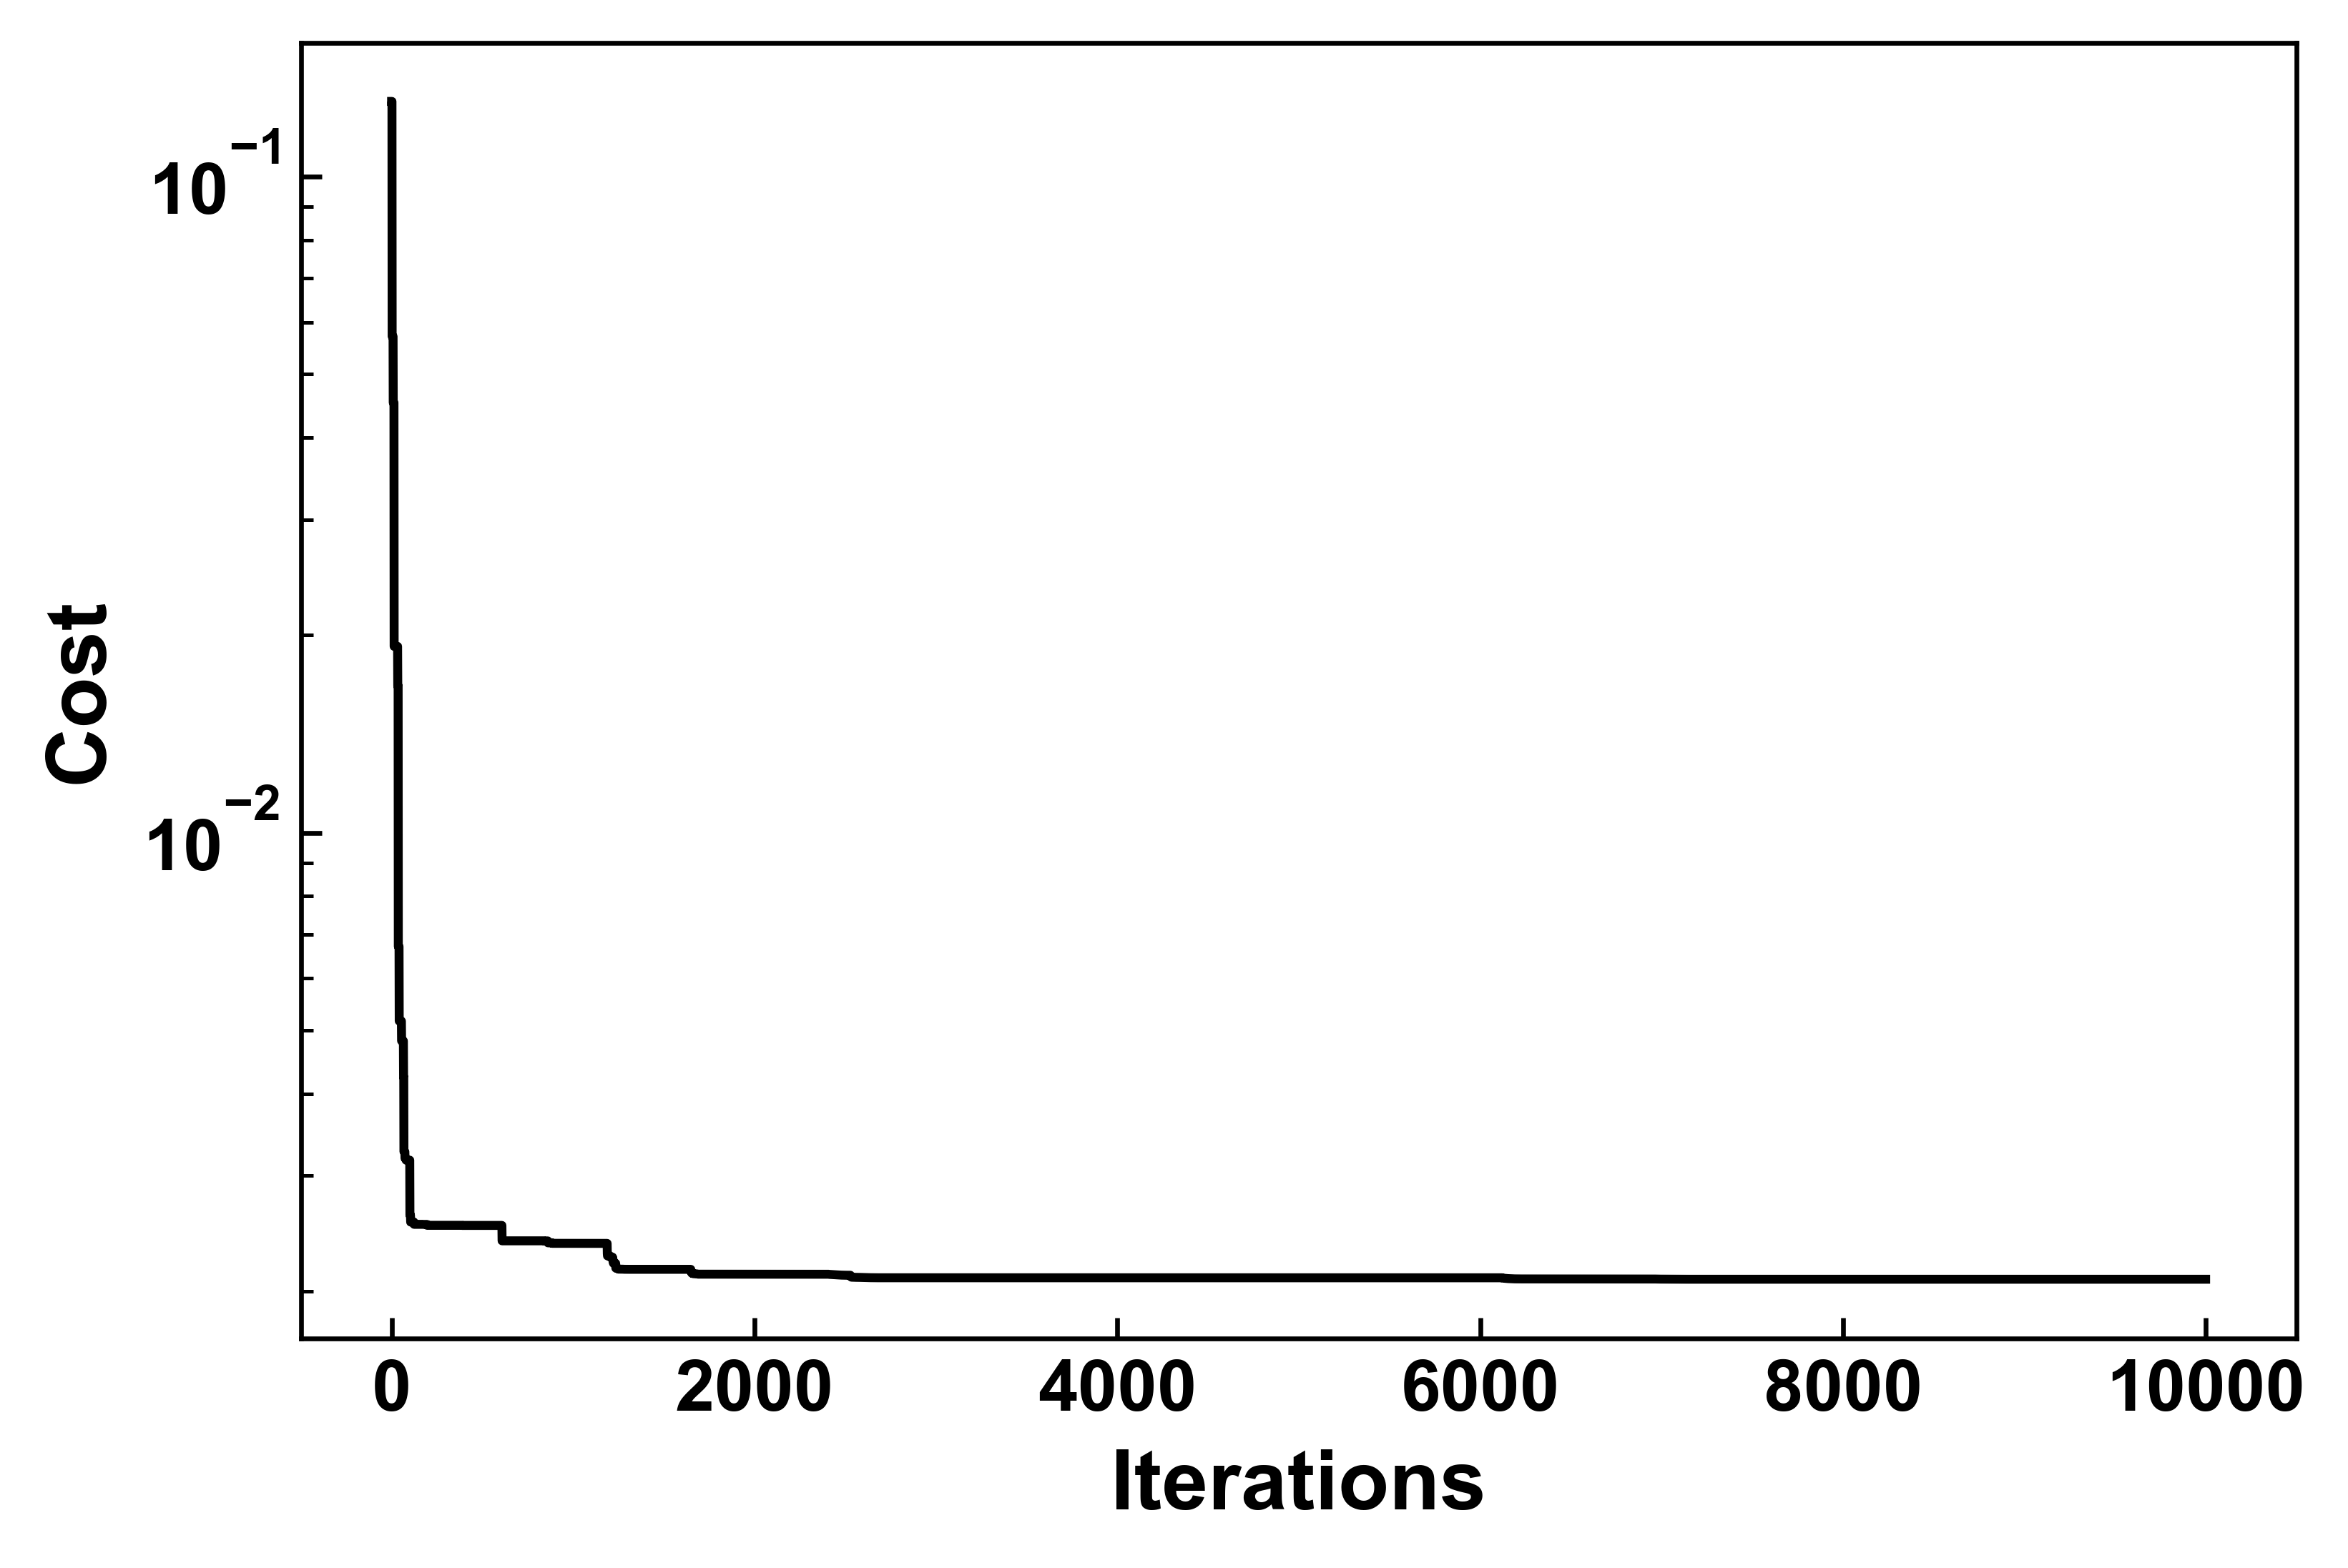

In [14]:
#plot_cost_history(cost_history=optimizer.cost_history)
med = 14
sml = 12
fontname = "Arial"
fig,ax = plt.subplots(dpi=600)
ax.plot(range(len(optimizer.cost_history)),optimizer.cost_history,'k-')
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')
ax.set_yscale('log')
ax.set_xlabel(r'Iterations',
             fontsize=med,
             fontweight="bold",
             fontname=fontname)
ax.set_ylabel(r'Cost',
             fontsize=med,
             fontweight="bold",
             fontname=fontname)
ax.tick_params(axis='both',
               which='both',
               labelsize=sml,
               direction = 'in')
plt.xticks(fontweight="bold",
           fontname=fontname)
plt.yticks(fontweight="bold",
           fontname=fontname)
plt.savefig('FIGURES/PSO_yesInitialization_costPerIteration.svg')
plt.show()

In [15]:
pos_scaled = scaler.transform(pos.reshape(1,-1))
y_pred_0 = reg_0.predict(pos_scaled)
y_pred_1 = reg_1.predict(pos_scaled)
y_pred_GPR = pd.DataFrame({performance[0]:y_pred_0,
                       performance[1]:y_pred_1
                       },index=['Inverse Performance'])

y_pred_GPR.loc['True Performance'] = y_true
dif = y_pred_GPR.loc['True Performance'] - y_pred_GPR.loc['Inverse Performance']
y_pred_GPR.loc['True - Inverse'] = dif
y_pred_GPR.loc['Percent Difference'] = np.abs(dif/y_true)*100

y_pred_GPR.to_excel('ANALYSIS/PSO_yesInitialization_outputs.xlsx')

y_pred_GPR

,Toughness (J/m2),Modulus (GPa)
Inverse Performance,632.778359,5.105009
True Performance,656.000000,5.100000
True - Inverse,23.221641,-0.005009
Percent Difference,3.539884,0.098222
